In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
ctf = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]

# Load dataset
train_loader = FromDataset(CIFAR10(True), batch_size=512, custom_tf=ctf)
test_loader = FromDataset(CIFAR10(False), batch_size=512)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Model
model = builder([
    SENet18(input_dim=3)
])

# Learning
runner = Runner(model, train_loader, test_loader, optimizer='adam', loss_fn='focal', monitor_mode='max')

In [5]:
runner.fit(20, 1e-3, mixup_alpha=0.4)

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1*       12.2040        0.2773       10.0666        0.4579    


    2*        8.9686        0.4010        5.2925        0.7342    


    3         7.4534        0.4144        5.8467        0.6926    


    4*        7.1791        0.4905        3.8658        0.8056    


    5         6.5687        0.4558        5.6113        0.7094    


    6*        6.4212        0.4944        3.5242        0.8302    


    7         6.0359        0.5432        5.1881        0.7325    


    8         5.6086        0.5197        3.7618        0.8127    


    9         4.3092        0.4602        4.9327        0.7542    


   10*        4.7204        0.4764        3.3715        0.8311    


    11        4.7293        0.5274        6.2937        0.7132    


   12*        5.3357        0.5191        3.3421        0.8373    


    13        4.9578        0.5266        4.5721        0.7837    


   14*        4.6036        0.4606        3.2972        0.8439    


    15        4.5191        0.5680        3.8082        0.8144    


   16*        4.7880        0.4706        2.9771        0.8513    


    17        3.8590        0.6140        3.8768        0.8008    


    18        4.7601        0.6067        3.2569        0.8442    


    19        3.7298        0.5418        3.9904        0.8036    


   20*        4.6542        0.5355        3.1949        0.8550    



3.1904138684272767 0.855


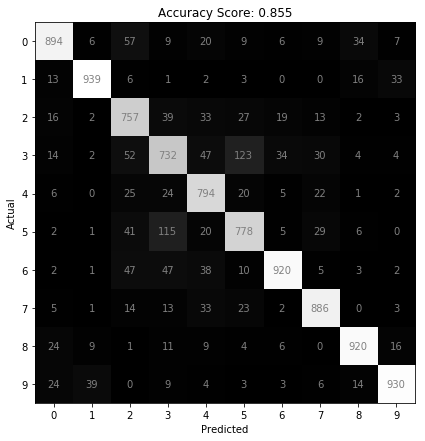

In [6]:
runner.validate(metrics=[ConfusionMatrix(plot=True, classes=10)])

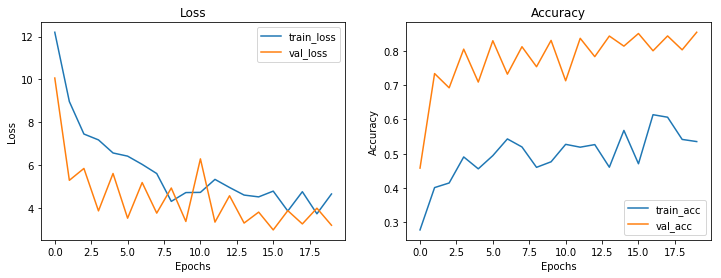

In [7]:
runner.history(plot=True)